# Evaluation

Evaluation on results

In [34]:
import pandas as pd

In [35]:
import pandas as pd

from c3p.datamodel import Dataset, \
    EvaluationResult

In [36]:
# ensure you have executed Generate-Dataset.ipynb first
# this has a list of chemical classes and their instances
with open("inputs/bench-236-2-5000.json") as f:
    dataset = Dataset.model_validate_json(f.read())
#dataset = Dataset.parse_file("inputs/dataset.json")
filtered_classes = dataset.classes
len(filtered_classes)

5974

## Run an individual experiment

In [37]:
from c3p.datamodel import Config

#model = "claude-3-sonnet"
model = "lbl/claude-sonnet"

# claude-sonnet seems best so far
config = Config(llm_model_name=model, 
                max_attempts=5,
                accuracy_threshold=0.95, 
                test_proportion=0.1,
                #max_negative_to_test=5000,
                )

In [38]:
from pathlib import Path

results_dir = Path("eval-latest")

In [39]:
# TODO: be careful as this reuses, do not mix experiments!
from c3p.generator import evaluate_for_class, safe_name

in_progress_dir = results_dir / "in-progress"
in_progress_dir.mkdir(parents=True, exist_ok=True)

n = 0
eval_results = []
for c in filtered_classes:
    n += 1
    if len(c.instances) < 10:
        continue
    # TODO
    if c.name in ["5beta steroid", "polysaccharide"]:
        continue
    #if len(c.instances) > 2500:
    #    # TODO: configure
    #    continue
    fn = in_progress_dir / f"{safe_name(c.name)}.json"
    if fn.exists():
        print(f"** Reusing {c.name} from {fn}  **")
        eval_results.append(EvaluationResult.model_validate_json(fn.read_text()))
        continue
    print(f"# Evaluating {c.name} pos={len(c.instances)} ({n}/{len(filtered_classes)})")
    result = evaluate_for_class(c, config, dataset=dataset)
    if not result:
        print(f"** Failed to evaluate {c.name} **")
        continue
    with open(fn, "w") as f:
        f.write(result.model_dump_json(indent=2))
    print(f"f1= {result.test_result.f1}")
    print(f"precision= {result.test_result.precision}")
    print(f"recall= {result.test_result.recall}")
    eval_results.append(result)
#eval_results = [evaluate_for_class(c, config) for c in filtered_classes[0:10]]

** Reusing wax ester from eval-latest/in-progress/wax_ester.json  **
** Reusing 2-hydroxy fatty acid from eval-latest/in-progress/2_hydroxy_fatty_acid.json  **
** Reusing omega-hydroxy fatty acid from eval-latest/in-progress/omega_hydroxy_fatty_acid.json  **
** Reusing 2-acylglycerophosphocholine(1+) from eval-latest/in-progress/2_acylglycerophosphocholine_1__.json  **
** Reusing 3-sn-phosphatidyl-L-serine from eval-latest/in-progress/3_sn_phosphatidyl_L_serine.json  **
** Reusing vitamin A from eval-latest/in-progress/vitamin_A.json  **
** Reusing steroid aldehyde from eval-latest/in-progress/steroid_aldehyde.json  **
** Reusing C27-steroid from eval-latest/in-progress/C27_steroid.json  **
** Reusing C24-steroid from eval-latest/in-progress/C24_steroid.json  **
** Reusing steroidal acyl-CoA(4-) from eval-latest/in-progress/steroidal_acyl_CoA_4__.json  **
** Reusing cholane derivative from eval-latest/in-progress/cholane_derivative.json  **
** Reusing HETE anion from eval-latest/in-pro

BadRequestError: Error code: 400 - {'error': {'message': 'Budget has been exceeded! Current cost: 50.044598999999934, Max budget: 50.0', 'type': 'budget_exceeded', 'param': None, 'code': '400'}}

In [7]:
    len(eval_results)

895

In [8]:
t = eval_results[0].test_result
t.precision, t.recall, t.f1

(0.6805555555555556, 0.98989898989899, 0.8065843621399177)

In [9]:
unsuccessful = [er for er in eval_results if not er.train_results.best_result.success]
len(unsuccessful)

143

In [10]:
unsuccessful[0].test_result.f1

0.0

In [11]:
from c3p.datamodel import EvaluationExperiment

In [12]:
expt = EvaluationExperiment(config=config, evaluation_results=eval_results)

In [13]:
expt.config.f1_threshold

0.8

In [14]:
%load_ext autoreload

In [15]:
%autoreload 2

In [16]:
from c3p.dumper import write_eval_results

In [17]:
config.f1_threshold = 0.0
df = write_eval_results(expt, results_dir, f1_threshold=-1)
#df["num_instances"] = df["num_positives"] + df["num_negatives"]

In [18]:
df

,chemical_class,message,true_positives,false_positives,true_negatives,false_negatives,attempt,success,best,error,...,precision,recall,f1,accuracy,num_instances,train_f1,train_precision,train_accuracy,train_attempt,num_test_instances
0,wax ester,None,[(CCCCCCCC\C=C/CCCCCCCC(=O)OCCCCCCCC\C=C/CCCCC...,[(CCCCCCCCCCCCCC(=O)OC\C=C(/C)CCC[C@H](C)CCC[C...,None,None,0,True,False,,...,0.680556,0.989899,0.806584,0.999744,0,0.298507,0.178571,0.999744,1,99
1,2-hydroxy fatty acid,None,"[(CC(C)C(O)(O)C(O)=O, 2-hydroxy fatty acid wit...",[(CC(C)[C@@H]1C[C@H](OC(=O)[C@@]2(C)O[C@H]2C)[...,None,None,0,True,False,,...,0.350649,1.000000,0.519231,0.961435,0,0.090909,0.047619,0.960692,0,54
2,omega-hydroxy fatty acid,None,"[(C(CCCC(CCCCCCO)=O)CCCCC(O)=O, Omega-hydroxy ...",[([C@H]1(O[C@@H]([C@H](O)[C@@H]([C@H]1O)O[C@]2...,None,None,0,True,False,,...,0.444444,0.952381,0.606061,0.968322,0,0.152542,0.082569,0.968828,0,84
4,3-sn-phosphatidyl-L-serine,None,[],[],None,None,0,True,False,,...,0.000000,0.000000,0.000000,0.999560,0,0.000000,0.000000,0.999957,0,81
5,vitamin A,None,[],[],None,None,0,True,False,,...,0.000000,0.000000,0.000000,0.999946,0,0.000000,0.000000,0.999995,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,annulene,None,[],[],None,None,0,True,False,,...,0.000000,0.000000,0.000000,0.999946,0,0.000000,0.000000,0.999995,0,10
889,d-block molecular entity,None,[([H][C@]12[C@H](CC(O)=O)[C@@](C)(CCC(O)=O)C3=...,[([Fe+2].O=NC1=C(O)C=CC(=C1)C(=O)OC2=CC=C(C=C)...,None,None,0,True,False,,...,0.858956,0.957547,0.905576,0.998170,0,0.559322,0.397590,0.998489,0,636
891,hydrides,None,[],[],None,None,0,True,False,,...,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,100
893,polyatomic cation,None,[([N@@+]12(CCC3=C([C@@]2(CC4=C(C1)C(=C(C=C4)O)...,[],None,None,0,True,False,,...,1.000000,0.411765,0.583333,0.411765,0,0.514563,1.000000,0.346405,0,170


In [19]:
import numpy as np

correlation = np.corrcoef(df["num_test_instances"], df["f1"])[0,1]
correlation

np.float64(0.4879127134883054)

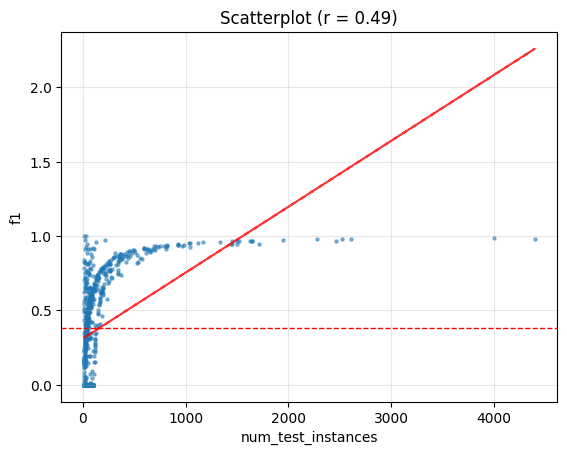

In [20]:
import matplotlib.pyplot as plt

def plot_scatter(df, x, y, title="Scatterplot"):
    correlation = np.corrcoef(df[x], df[y])[0,1]
    title = f"{title} (r = {correlation:.2f})"
    plt.scatter(df[x], df[y], s=5, alpha=0.5)
    # draw a line through the mean
    plt.axhline(df[y].mean(), color='red', linestyle='dashed', linewidth=1)
    z = np.polyfit(df[x], df[y], 1)
    p = np.poly1d(z)
    plt.plot(df[x], p(df[x]), "r--", alpha=0.8)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.savefig(results_dir / f"scatterplot-{x}-{y}.png",
                dpi=300,              # High resolution
                bbox_inches='tight',  # Removes extra white spaces
                pad_inches=0.1,       # Small padding around the figure
                format='png',         # Format type
                transparent=False,    # White background
                facecolor='white',    # Figure face color
                edgecolor='none',     # No edge color
                )
    
    plt.show()
    
plot_scatter(df, "num_test_instances", "f1",)

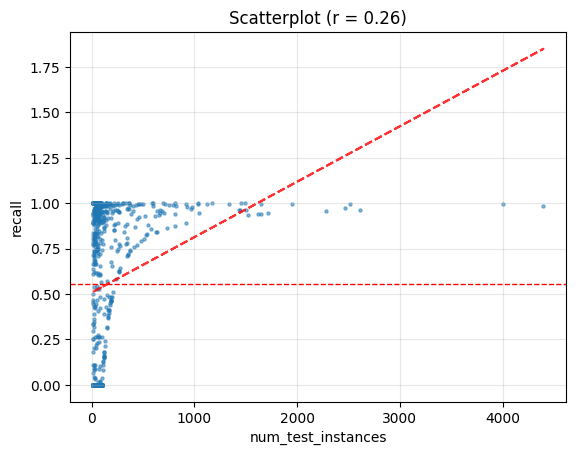

In [21]:
plot_scatter(df, "num_test_instances", "recall")


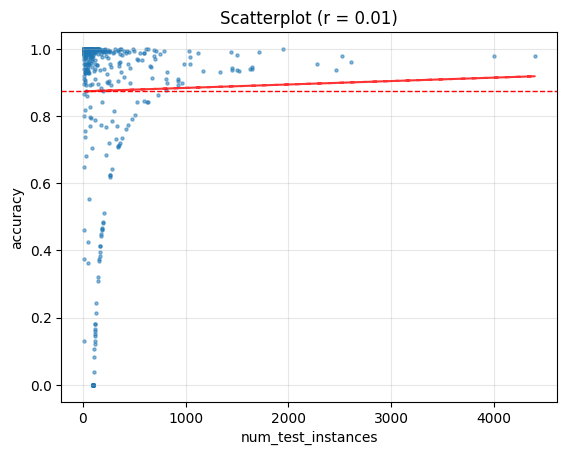

In [22]:
plot_scatter(df, "num_test_instances", "accuracy")

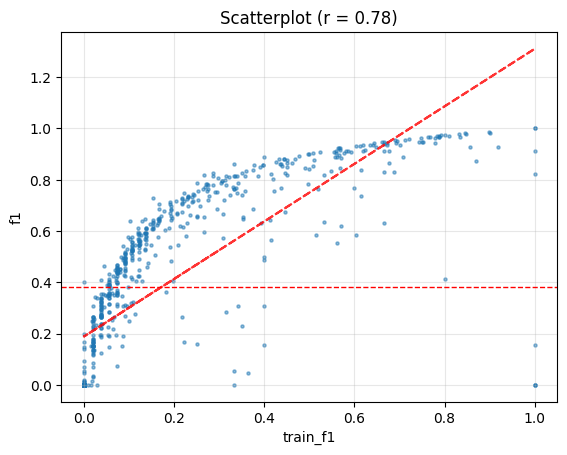

In [23]:
plot_scatter(df, "train_f1", "f1")


In [24]:
from c3p.stats import calculate_metrics_pandas


def micro_stats(df):
    df["f1_score"] = df["f1"]
    return df.select_dtypes(include=['int64', 'float64']).mean()

def macro_stats(df):
    return calculate_metrics_pandas(df)

def calculate_stats(df):
    sdf = pd.DataFrame(
        {
            'micro': micro_stats(df),
            'macro': macro_stats(df),
        },
    )
    sdf = sdf.transpose()
    return sdf[["f1_score", "precision", "recall", "accuracy"]].round(3)
    

calculate_stats(df)

,f1_score,precision,recall,accuracy
micro,0.382,0.355,0.556,0.875
macro,0.757,0.705,0.817,0.999


In [25]:
calculate_stats(df[df["num_test_instances"] > 100])

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_46728/2140089736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["f1_score"] = df["f1"]


,f1_score,precision,recall,accuracy
micro,0.753,0.796,0.802,0.839
macro,0.884,0.862,0.908,0.995


In [26]:
calculate_stats(df[df["num_test_instances"] > 150])

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_46728/2140089736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["f1_score"] = df["f1"]


,f1_score,precision,recall,accuracy
micro,0.824,0.835,0.855,0.876
macro,0.904,0.885,0.925,0.993


In [27]:
calculate_stats(df[(df["num_test_instances"] > 150) & (df["train_f1"] > 0.5)])

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_46728/2140089736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["f1_score"] = df["f1"]


,f1_score,precision,recall,accuracy
micro,0.901,0.933,0.893,0.891
macro,0.944,0.938,0.950,0.994


In [28]:
filtered_df = df[(df["num_test_instances"] > 150) & (df["train_f1"] > 0.5)]
filtered_df.to_csv(results_dir / "filtered.csv")
filtered_df

,chemical_class,message,true_positives,false_positives,true_negatives,false_negatives,attempt,success,best,error,...,recall,f1,accuracy,num_instances,train_f1,train_precision,train_accuracy,train_attempt,num_test_instances,f1_score
29,dicarboxylic acids and O-substituted derivatives,None,"[(OC(=O)\C=C/C(O)=C\C(O)=O, Dicarboxylic acid)...",[(O=C(N[C@H](C(=O)N[C@@H](CC=1C=2C(NC1)=CC=CC2...,None,None,0,True,False,,...,0.985348,0.935110,0.931077,0,0.640569,0.473684,0.887402,1,819,0.935110
147,secondary carboxamide,None,[(CC(C)c1cc(\C=C(/C#N)C(=O)NCCCc2ccccc2)cc(C(C...,[(O([C@@H]1[C@H](O)[C@H](O[C@H]2[C@H](O)[C@@H]...,None,None,0,True,False,,...,0.996359,0.968732,0.945049,0,0.782796,0.645390,0.782328,0,1648,0.968732
217,primary alcohol,None,"[(OCC=Cc1ccc(O)cc1, Contains primary alcohol g...",[(COC1=CC=C(C=C1)S(=O)(=O)N[C@H]2CC[C@@H](O[C@...,None,None,0,True,False,,...,0.979437,0.938310,0.909021,0,0.666667,0.502488,0.792181,1,924,0.938310
223,long-chain fatty acid,None,[(O[C@@H](C/C=C\C/C=C\CCCC(O)=O)/C=C/C=C\C/C=C...,"[(O1C(CCCCCCCC(O)=O)=C(C(=C1CCC)C)C, Long-chai...",None,None,0,True,False,,...,0.946939,0.944461,0.990005,0,0.778947,0.649123,0.994029,1,1715,0.944461
225,phosphatidylethanolamine,None,[(P(OC[C@H](OC(=O)CC/C=C\C/C=C\C/C=C\C/C=C\C/C...,[(P(OCC[N+](C)(C)C)(OC[C@H](OC(=O)C(C(C(C(C(C(...,None,None,0,True,False,,...,0.998060,0.952778,0.993682,0,0.695122,0.532710,0.993433,3,1031,0.952778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,alkali metal molecular entity,None,"[([Na+].C(/C=C/C([O-])=O)(O)=O, Molecule conta...",[([Na+].[H][C@@]12CC[C@]3(C)[C@]([H])(C[C@@H](...,None,None,0,True,False,,...,0.997934,0.905342,0.997906,0,0.507317,0.342105,0.997887,0,484,0.905342
857,transition element molecular entity,None,[(OS(=O)(=O)c1ccc2O[Cu]Oc3c(\N=N\c2c1)c(cc1c(c...,[([Fe+2].O=NC1=C(O)C=CC(=C1)C(=O)OC2=CC=C(C=C)...,None,None,0,True,False,,...,0.959361,0.911724,0.997183,0,0.580645,0.418605,0.997680,2,689,0.911724
864,glycolipid,None,[([H][C@]1(O[C@@](C[C@H](O)[C@H]1NC(=O)CO)(O[C...,[(OC(/C=C/[C@@H](O)[C@H]([C@@H]1[C@@]2([C@@](C...,None,None,0,True,False,,...,1.000000,0.966777,0.937383,0,0.763033,0.616858,0.669967,1,1455,0.966777
889,d-block molecular entity,None,[([H][C@]12[C@H](CC(O)=O)[C@@](C)(CCC(O)=O)C3=...,[([Fe+2].O=NC1=C(O)C=CC(=C1)C(=O)OC2=CC=C(C=C)...,None,None,0,True,False,,...,0.957547,0.905576,0.998170,0,0.559322,0.397590,0.998489,0,636,0.905576


In [29]:
calculate_stats(filtered_df).to_csv(results_dir / "filtered-summary.csv")
calculate_stats(filtered_df)

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_46728/2140089736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["f1_score"] = df["f1"]
/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_46728/2140089736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["f1_score"] = df["f1"]


,f1_score,precision,recall,accuracy
micro,0.901,0.933,0.893,0.891
macro,0.944,0.938,0.950,0.994


In [30]:
calculate_stats(df[df["train_f1"] > 0.5])


/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_46728/2140089736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["f1_score"] = df["f1"]


,f1_score,precision,recall,accuracy
micro,0.854,0.903,0.840,0.917
macro,0.942,0.937,0.946,0.998


In [31]:
calculate_stats(df).to_csv(results_dir / "summary.csv")

In [32]:
top_left_df = df[(df["num_test_instances"] < 100) & (df["f1"] > 0.8)]
top_left_df

,chemical_class,message,true_positives,false_positives,true_negatives,false_negatives,attempt,success,best,error,...,recall,f1,accuracy,num_instances,train_f1,train_precision,train_accuracy,train_attempt,num_test_instances,f1_score
0,wax ester,None,[(CCCCCCCC\C=C/CCCCCCCC(=O)OCCCCCCCC\C=C/CCCCC...,[(CCCCCCCCCCCCCC(=O)OC\C=C(/C)CCC[C@H](C)CCC[C...,None,None,0,True,False,,...,0.989899,0.806584,0.999744,0,0.298507,0.178571,0.999744,1,99,0.806584
15,docosanoid anion,None,[(C(C([O-])=O)C/C=C\C/C=C\C\C=C/C=C/[C@@H](C/C...,[([H][C@]12CC[C@@]3(C)[C@@]([H])(CC[C@@]3(O)CC...,None,None,0,True,False,,...,0.941176,0.860215,0.999859,0,0.333333,0.222222,0.999869,1,85,0.860215
30,S-acyl-4'-phosphopantetheine(2-),None,[(C(NC(CCNC(=O)[C@@H](C(COP([O-])(=O)[O-])(C)C...,[(CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP([O-])(...,None,None,0,True,False,,...,1.000000,0.974359,0.999995,0,0.800000,0.666667,0.999995,0,19,0.974359
46,phthalic acid monoester,None,"[(C=1C=CC(=C(C1)C(=O)OC)C(=O)O, Valid phthalic...",[],None,None,0,True,False,,...,0.700000,0.823529,0.999967,0,1.000000,1.000000,1.000000,3,20,0.823529
47,lysophosphatidic acid,None,[(P(OC[C@H](O)COC(=O)CCCCCCC/C=C\CCCC)(O)(O)=O...,[(CCCCC\C=C/C\C=C/C\C=C/CCCCC(=O)OC[C@@H](O)CO...,None,None,0,True,False,,...,0.723077,0.831858,0.999897,0,0.666667,0.800000,0.999978,0,65,0.831858
65,hydroperoxy polyunsaturated fatty acid anion,None,[(O(O)[C@@H](CCCC([O-])=O)/C=C/C=C\C/C=C\C/C=C...,[(C(CCC)C[C@@H](/C=C/C=C\C/C=C\C/C=C\CCCC(NCCC...,None,None,0,True,False,,...,1.000000,0.880000,0.999886,0,0.432432,0.275862,0.999886,1,77,0.880000
127,(13)C-modified compound,None,[([13CH3]N1C=NC2=C1C(=O)N([13CH3])C(=O)N2[13CH...,[(O=C([C@]1([13C@H](C(=C[C@@H]2[C@@H]1[C@@H](C...,None,None,0,True,False,,...,0.892857,0.925926,0.999978,0,0.857143,0.750000,0.999995,1,28,0.925926
179,"1-radyl,2-acyl-sn-glycero-3-phospho-(1D-myo-2-...",None,[(O[C@H]1[C@H](O)[C@@H](O)[C@H](OP([O-])(=O)OC...,[([C@@H]1([C@@H]([C@@H]([C@@H]([C@H]([C@@H]1O)...,None,None,0,True,False,,...,0.971429,0.912752,0.999929,0,0.560000,0.388889,0.999940,2,70,0.912752
250,N-(fatty acyl)-ethanolamine,None,"[(CCCCCC=CCC=CCC=CCC=CCCCCCC(=O)NCCO, N-(fatty...","[(O=C(NCCO)/C(=C/CC/C=C/CCCCCCCCCCCCC)/C, N-(f...",None,None,0,True,False,,...,1.000000,0.810811,0.999886,0,0.322581,0.192308,0.999886,4,45,0.810811
261,monoacyl-sn-glycerol 3-phosphate,None,[(P(OCC(O)COC(=O)CCCCCCCCC/C=C\C/C=C\CCCCC)(O)...,[([H]C(CCCCCCCC)=C([H])CCCCCCCC(=O)OCC(O)COP(O...,None,None,0,True,False,,...,0.750000,0.818182,0.999891,0,0.533333,0.444444,0.999962,0,60,0.818182


In [33]:
list(top_left_df["chemical_class"].values)

['wax ester',
 'docosanoid anion',
 "S-acyl-4'-phosphopantetheine(2-)",
 'phthalic acid monoester',
 'lysophosphatidic acid',
 'hydroperoxy polyunsaturated fatty acid anion',
 '(13)C-modified compound',
 '1-radyl,2-acyl-sn-glycero-3-phospho-(1D-myo-2-acyl-inositol)(1-)',
 'N-(fatty acyl)-ethanolamine',
 'monoacyl-sn-glycerol 3-phosphate',
 'icosanol',
 'very long-chain fatty alcohol',
 'alkyl group',
 'alpha-hydroxynitrile',
 'pentacosanol',
 'cycloalkane',
 'inositol',
 'metal-sulfur cluster',
 'organomercury compound',
 'polonium atom']